In [197]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [198]:
df = pd.read_csv("data/diabetes_feature.csv")
df.shape

(768, 16)

In [199]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_high,Age_low,Age_middle,Age_high,Insulin_nan,Insulin_log,low_glu_insulin
0,6,148,72,35,0,33.6,0.627,50,1,False,False,True,False,206.0,5.332719,False
1,1,85,66,29,0,26.6,0.351,31,0,False,False,True,False,130.0,4.875197,False
2,8,183,64,0,0,23.3,0.672,32,1,True,False,True,False,206.0,5.332719,False
3,1,89,66,23,94,28.1,0.167,21,0,False,True,False,False,94.0,4.553877,True
4,0,137,40,35,168,43.1,2.288,33,1,False,False,True,False,168.0,5.129899,False


## 학습과 예측에 사용할 데이터셋 만들기

In [200]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'Pregnancies_high',
       'Age_low', 'Age_middle', 'Age_high', 'Insulin_nan', 'Insulin_log',
       'low_glu_insulin'],
      dtype='object')

In [201]:
# feature engineering 결과 더 잘 나왔던 변수들만 사용하도록 - 예측변수

X = df[[ 'Glucose', 'BloodPressure', 'SkinThickness',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Pregnancies_high',
       'Insulin_nan', 'low_glu_insulin']]
X.shape

(768, 9)

In [202]:
y = df['Outcome']
y.shape

(768,)

In [203]:
# 사이킷런에서 제공하는 model_selection의 train_test_split으로 만든다.
# random state 는 매번 실행때마다 결과가 달라지는 것을 방지.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [204]:
X_train.shape

(614, 9)

In [205]:
y_train.shape

(614,)

In [206]:
X_test.shape, y_test.shape

((154, 9), (154,))

### 최적의 max_depth 값 찾기(조정만 해줘도 성능 향상)

In [207]:
from sklearn.metrics import accuracy_score

for max_depth in range(3, 12):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    y_predict = model.fit(X_train, y_train).predict(X_test)
    score = accuracy_score(y_test, y_predict) * 100
    print(max_depth, score)

3 83.76623376623377
4 84.4155844155844
5 86.36363636363636
6 85.06493506493507
7 83.11688311688312
8 83.76623376623377
9 83.11688311688312
10 83.76623376623377
11 83.11688311688312


* hyper parameter 찾는 것의 문제

## Grid Search

In [208]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier(random_state=42)
param_grid = {"max_depth": range(3, 12),
"max_features": [0.3, 0.5, 0.7, 0.9, 1]}
clf = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=2)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 210 out of 225 | elapsed:   13.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   13.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(3, 12),
                         'max_

In [209]:
# 가장 성능이 좋은 파라미터
clf.best_params_

{'max_depth': 7, 'max_features': 0.7}

In [210]:
# 가장 좋은 성능을 내는 파라미터 조합 전체 
clf.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=0.7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [211]:
# 가장 좋은 점수
clf.best_score_

0.871398107423697

In [212]:
#  cv_results_는 cross validation 결과를 데이터프레임으로 반환합니다. score을 내림차순으로 확인할 수 있습니다.
pd.DataFrame(clf.cv_results_).sort_values(by="rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,0.012166,0.001465,0.003790,0.000747,7,0.7,"{'max_depth': 7, 'max_features': 0.7}",0.829268,0.886179,0.869919,0.861789,0.909836,0.871398,0.026704,1
17,0.018351,0.006135,0.003591,0.000797,6,0.7,"{'max_depth': 6, 'max_features': 0.7}",0.853659,0.894309,0.821138,0.821138,0.885246,0.855098,0.030838,2
23,0.012367,0.000488,0.003191,0.000398,7,0.9,"{'max_depth': 7, 'max_features': 0.9}",0.829268,0.894309,0.837398,0.829268,0.868852,0.851819,0.025770,3
12,0.008974,0.000630,0.002992,0.000630,5,0.7,"{'max_depth': 5, 'max_features': 0.7}",0.804878,0.910569,0.829268,0.861789,0.852459,0.851793,0.035393,4
1,0.016954,0.006369,0.004986,0.000892,3,0.5,"{'max_depth': 3, 'max_features': 0.5}",0.861789,0.886179,0.788618,0.845528,0.868852,0.850193,0.033439,5


In [213]:
# 예측을 진행하여 답안지를 만듦
clf.predict(X_test)

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
      dtype=int64)

In [214]:
clf.score(X_test, y_test)

0.8311688311688312

* 단점 : 우리가 지정해준 범위 내에서만 최적의 파라미터 찾을 수 있음.

## Random Search CV

* 훨씬 더 랜덤하게

In [215]:
model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [216]:
# 1부터 20까지 랜덤하게 10개 추출
# 원래 max_depth = np.random.randint(3, 20, 10)였는데, 마지막에 cv_result 봤을 때에서 최소 4정도여서 3으로 다시 바꿈

max_depth = np.random.randint(3, 20, 10)
max_depth

array([13, 11, 16, 15, 16, 13,  8,  7, 10, 10])

In [217]:
max_features = np.random.uniform(0.4, 1.0, 100)

In [218]:
param_distributions = {'max_depth': max_depth, 'max_features': max_features, 'min_samples_split' : list(range(2,7))}
param_distributions

{'max_depth': array([13, 11, 16, 15, 16, 13,  8,  7, 10, 10]),
 'max_features': array([0.43123184, 0.5037532 , 0.76638565, 0.57808589, 0.9344729 ,
        0.78912078, 0.93603817, 0.9107862 , 0.97380066, 0.46724301,
        0.61886588, 0.89971041, 0.81669474, 0.80934275, 0.8796573 ,
        0.49627456, 0.61739017, 0.82265427, 0.89618927, 0.88470493,
        0.6908307 , 0.78248067, 0.68335779, 0.55718497, 0.64825135,
        0.94180497, 0.73588668, 0.7722347 , 0.44966143, 0.65919356,
        0.99943691, 0.87394788, 0.41651999, 0.82275041, 0.95218432,
        0.92726444, 0.99328393, 0.43656771, 0.49940164, 0.90753994,
        0.43305058, 0.91027473, 0.71073475, 0.90215785, 0.92935209,
        0.42990198, 0.9043062 , 0.74625244, 0.40002069, 0.97460539,
        0.55214486, 0.77291353, 0.77494327, 0.90706834, 0.97886969,
        0.56578267, 0.8895683 , 0.545664  , 0.57806351, 0.81014943,
        0.41826182, 0.45168045, 0.88469449, 0.6696875 , 0.55752673,
        0.94265336, 0.50769876, 0.428

In [219]:
# n_iter ; 몇 번 반복 (100은 앞에서 랜덤하게 100개)

from sklearn.model_selection import RandomizedSearchCV

clf = RandomizedSearchCV(model, 
                   param_distributions,
                   n_iter=100,
                   scoring='accuracy',
                   n_jobs = -1,
                   cv=5,
                   random_state=42)

clf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=42,
            

In [220]:
clf.best_params_

{'min_samples_split': 2, 'max_features': 0.8284326034506684, 'max_depth': 8}

In [221]:
clf.best_score_

0.859962681594029

In [222]:
# Grid Search의 0.8311688311688312 보다 약간 향상됨.
# 사실 max_depth를 4로 했을 때 더 좋게 나오진 않음.
# 앞에서 n_iter를 많이 해주면 더 좋은 결과를 낼 수도 있음.

clf.score(X_test, y_test)

0.8376623376623377

In [223]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').head()

# max depth가 최소 4부터 좋게 나타남 -> 앞선 max_depth에서 시작을 3정도로 바꿔준다.
# max featrues는 대충 0.5정도부터 좋게 나타남 -> 0.4부터 시작?

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
66,0.012965,0.001669,0.003790,0.000399,2,0.828433,8,"{'min_samples_split': 2, 'max_features': 0.828...",0.861789,0.894309,0.796748,0.869919,0.877049,0.859963,0.033377,1
63,0.017553,0.005801,0.003990,0.001545,4,0.972742,7,"{'min_samples_split': 4, 'max_features': 0.972...",0.837398,0.894309,0.829268,0.869919,0.852459,0.856671,0.023376,2
68,0.011969,0.001093,0.003391,0.000489,4,0.993284,7,"{'min_samples_split': 4, 'max_features': 0.993...",0.837398,0.894309,0.829268,0.869919,0.852459,0.856671,0.023376,2
36,0.012167,0.001162,0.003790,0.000746,2,0.822654,7,"{'min_samples_split': 2, 'max_features': 0.822...",0.796748,0.894309,0.837398,0.869919,0.868852,0.853445,0.033618,4
45,0.011170,0.000977,0.004189,0.000747,3,0.614984,7,"{'min_samples_split': 3, 'max_features': 0.614...",0.804878,0.894309,0.853659,0.845528,0.868852,0.853445,0.029424,4


## Decision Tree

* 조건에 따라 True/False로 나뉘면서 sample 계수가 줄어들고, gini가 0이 될때 그만. 
* 시각화에 용이
* 지도분류 학습에서 가장 유용하게 사용하고 있는 기법이다.

* 분류 트리 분석 : 예측된 결과로 입력 데이터가 분류되는 클래스를 출력 (구매여부 등)
* 회귀 트리 분석 : 예측된 결과로 특정 의미를 지니는 실수 값을 출력 (주택의 가격 등)

* 앙상블 방법 : 여러개 사용해서 더 좋은. Bootstrap aggregating -> sample data 여러 개 추출해서 여러 개 트리를 그린다. 오버피팅 현상 조금 줄여줄 수 있음.<br>
; 반복적으로 교체 과정을 수행하고 훈련 데이터를 재 샘플링하고, 합의 예측을 위한 트리를 선택하는 것으로 다수의 의사 결정 트리 생성

### Decision Tree - SingleTree

* 5.2 옵션 해제하고 그대로 다른 것들 수행해주면 됨.

In [187]:
# DecisionTree를 불러온다. (당뇨병여부를 예측하는 것이기 때문에 Classifier)
# 옵션 값 조정하면 성능도 달라진다.
# 모델 시각화하기 용이하다는 장점이 있다.

## from sklearn.tree import DecisionTreeClassifier

## model = DecisionTreeClassifier(random_state = 42, max_depth = 5)
## model

### Bagging - RandomForest

In [238]:
##from sklearn.ensemble import RandomForestClassifier

##model = RandomForestClassifier(random_state=42)
##model

In [225]:
feature_names = X_train.columns.tolist()

In [239]:
# from sklearn.tree import plot_tree

# tree라는 변수에 할당을 해줘야지 그림으로 나타난다.
# tree 맨 밑에 보면 sample 수가 1개 뭐 이딴식인데 이럼 overfitting -> decision tree 옵션 변경으로 개선

# plt.figure(figsize=(15,15))
# tree = plot_tree(model, fontsize=10, feature_names = feature_names, filled = True)

### Boosting - GradientBoosting

* 샘플링 한거에서 가중치. 다음 샘플링. 그리고 또 가중치 적용해서 샘플링

In [264]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=42)
model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## 학습과 예측하기

In [265]:
# 학습을 시킨다.

model.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [266]:
model.feature_importances_

array([0.11099012, 0.00776988, 0.10211075, 0.03584765, 0.02933404,
       0.09548332, 0.        , 0.61846424, 0.        ])

In [267]:
feature_names = X_train.columns.tolist()

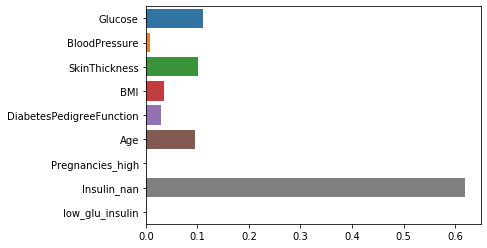

In [268]:
sns.barplot(x=model.feature_importances_, y=feature_names)

In [269]:
y_predict = model.predict(X_test)
y_predict[:5]

array([1, 0, 0, 0, 0], dtype=int64)

## 정확도(Accuracy) 측정하기

In [270]:
# 다르게 예측한 개수를 구해서 diff_count에 할당한다.
# 지난 feature 이전에 했을 때 정확도와 다르다. : 지난번에는 위에서 순서대로 20 80 이런식으로 테스트와 트레인 데이터셋을 나눠주었지만, 이번에는 사이킷런을 통해 랜덤으로 나누어주었기 때문이다.
# 그래서 계속 다시 정확도 측정하면 랜덤하게 또 다 다르게 나온다 결과가!!!
# 그래서 DecisionTree에서 random state로 설정해서 동일한 조건에서 동일한 결과가 나오게 해준다.

# max_dept로 조절하면 정확도 향상

# abs(y_predict - y_test).sum() 혹은

(y_predict != y_test).sum()

# Decision tree 1 : 21
# Random Forest : 21

22

In [271]:
# accuracy score

from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_predict) * 100

85.71428571428571

* 처음 83% (지난번 결과는 overfitting) -> max_dept 조정(=5) 86% -> Random Forest 83% -> GradientBoosting 22개 85%

* GradientBoosting 이 효과가 가장 좋아서 이걸 사용하고 싶을 수도 있지만, 랜덤으로 찾기 : RandomSearchCV